In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix
from sklearn.metrics.pairwise import cosine_similarity
import itertools
import scipy
import sys
import plotly.express as px
from plotly.subplots import make_subplots

eps = sys.float_info.epsilon

np.random.seed(222)

In [4]:
# files upload
from google.colab import files
uploaded = files.upload()

Saving data_banknote_authentication.txt to data_banknote_authentication (2).txt


In [5]:
df = pd.read_csv('data_banknote_authentication.txt', header=None, na_values=['?', 'N/A', 'na'])

In [6]:
#df = df[[0,1,2,3,4]].astype(float) # remove 4th feature
print(df.head())

#drop target
y = df[df.columns[len(df.columns)-1]].to_numpy() 
df.drop(columns=[df.columns[len(df.columns)-1]], inplace = True)

print('number of NA:',df.isna().sum().sum()) #no NA

X = df.to_numpy()
print('X shape:', X.shape)
print('y shape:', y.shape)

         0       1       2        3  4
0  3.62160  8.6661 -2.8073 -0.44699  0
1  4.54590  8.1674 -2.4586 -1.46210  0
2  3.86600 -2.6383  1.9242  0.10645  0
3  3.45660  9.5228 -4.0112 -3.59440  0
4  0.32924 -4.4552  4.5718 -0.98880  0
number of NA: 0
X shape: (1372, 4)
y shape: (1372,)


In [7]:
np.random.seed(2222)
make_balanced = False    # we tried to made the classes balanced but it didn't change much, so we set it to False

y[y==0] = -1
n_pos = (y==1).sum()
n_neg = (y==-1).sum()

# to make the 2 classes balanced
if make_balanced:
    index_to_remove = np.random.choice(np.where(y == -1)[0], size=int(n_neg - n_pos), replace = False)
    X= np.delete(X,index_to_remove, axis = 0)
    y = np.delete(y, index_to_remove)
    n_pos = (y==1).sum()
    n_neg = (y==-1).sum()

n_samples = X.shape[0]
n_features = X.shape[1]

for i in range(n_features):
  scaler = MinMaxScaler()
  X[:,i] = scaler.fit_transform(X[:,i].reshape(-1,1)).ravel()

# we keep only few of the label of the 2 cluster
delta = 0.05
delta_neg = delta
delta_pos = delta #*(n_neg / n_pos)
n_labeled = int(n_neg * delta_neg) + int(n_pos * delta_pos)
index_neg = np.random.choice(np.where(y ==-1)[0], size=int(n_neg * delta_neg), replace=False)
index_pos = np.random.choice(np.where(y == 1)[0], size=int(n_pos * delta_pos), replace=False)

# create set of labelled and unlabelled X and y
index_labeled = np.concatenate((index_neg, index_pos))
X_labeled = X[index_labeled]
y_labeled = y[index_labeled]

n_unlabeled = n_samples - n_labeled
X_unlabeled = np.delete(X, index_labeled, axis=0)
y_unlabeled = np.delete(y, index_labeled)

# print shapes
print('n samples:', n_samples, '--- n features:', n_features)
print('n labeled:', n_labeled, '--- n unlabeled:', n_unlabeled)
print('n labeled neg:', int(n_neg * delta_neg),'n labeled pos:', int(n_pos * delta_pos))

print('shape X:', X_labeled.shape, X_unlabeled.shape)
print('n neg:', n_neg, '--- n pos:', n_pos)
print('delta neg:', delta_neg, '--- delta pos:', delta_pos)


n samples: 1372 --- n features: 4
n labeled: 68 --- n unlabeled: 1304
n labeled neg: 38 n labeled pos: 30
shape X: (68, 4) (1304, 4)
n neg: 762 --- n pos: 610
delta neg: 0.05 --- delta pos: 0.05


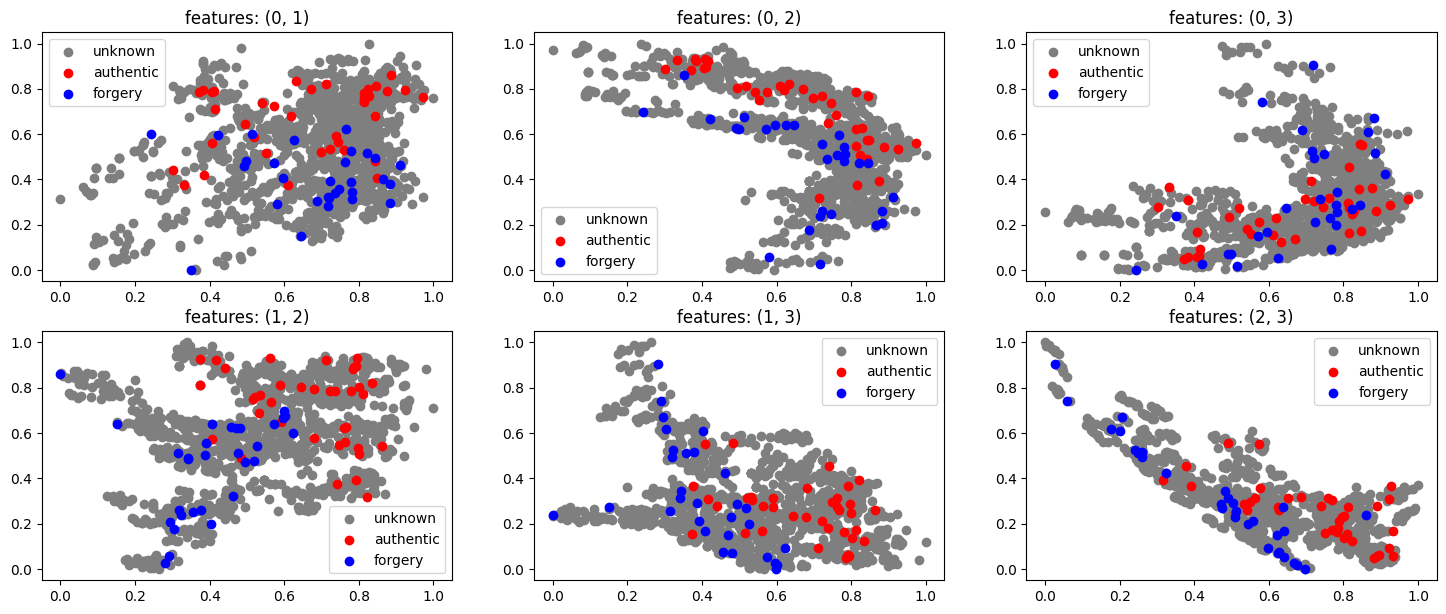

In [8]:
plt.figure(figsize=(18,11))
tup = list(itertools.combinations(range(n_features), 2))

for i, (l1, l2) in enumerate(tup):
    plt.subplot(len(tup)//3+1, 3, i+1)
    plt.scatter(X_unlabeled[:, l1-1], X_unlabeled[:, l2-1], c='tab:gray', label='unknown')
    plt.scatter(X[:, l1-1][index_neg], X[:, l2-1][index_neg], c='r', label='authentic')
    plt.scatter(X[:, l1-1][index_pos], X[:, l2-1][index_pos], c='b', label='forgery')
    plt.legend()
    plt.title(f'features: ({l1}, {l2})')

plt.show()

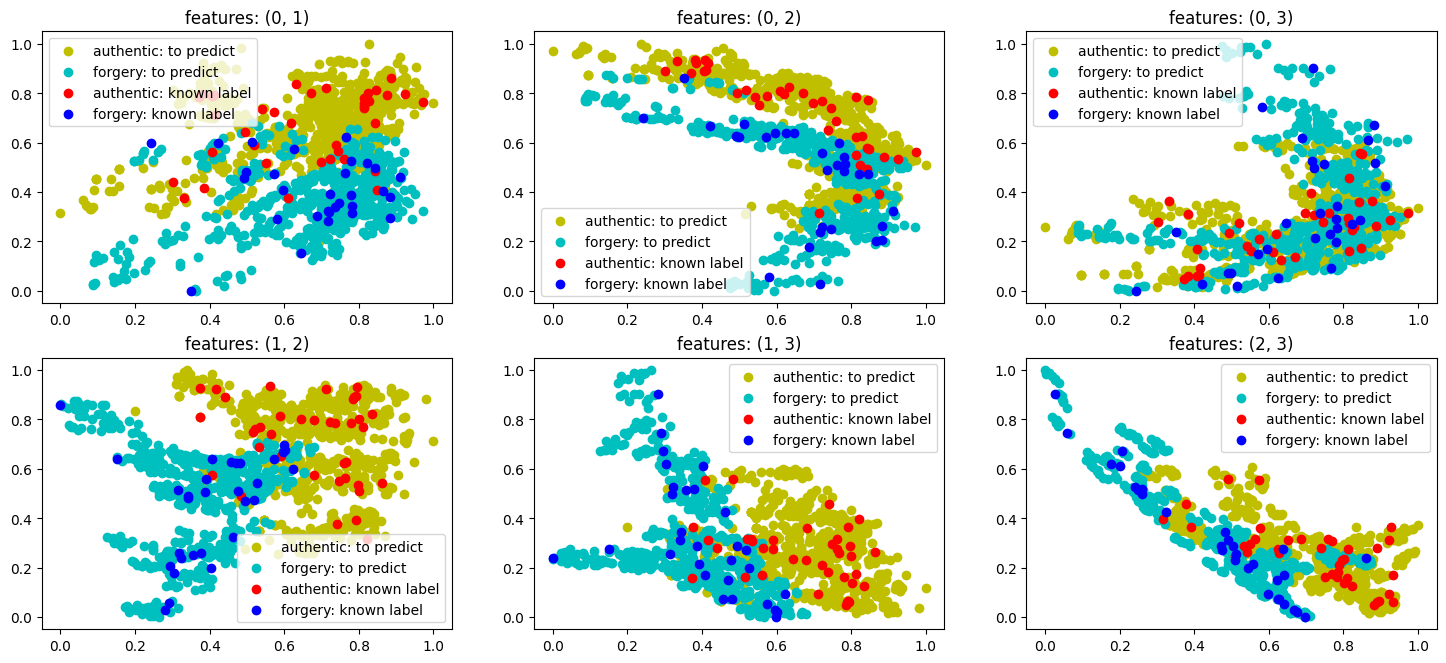

In [9]:
plt.figure(figsize=(18,12))
tup = list(itertools.combinations(range(n_features), 2))
for i, (l1, l2) in enumerate(tup):
    plt.subplot(len(tup)//3 +1, 3, i+1)
    plt.scatter(X_unlabeled[:, l1-1][y_unlabeled == -1], X_unlabeled[:, l2-1][y_unlabeled == -1], c='y', label='authentic: to predict')
    plt.scatter(X_unlabeled[:, l1-1][y_unlabeled == 1], X_unlabeled[:, l2-1][y_unlabeled == 1], c='c', label='forgery: to predict')
    plt.scatter(X[:, l1-1][index_neg], X[:, l2-1][index_neg], c='r', label='authentic: known label')
    plt.scatter(X[:, l1-1][index_pos], X[:, l2-1][index_pos], c='b', label='forgery: known label')
    plt.legend()
    plt.title(f'features: ({l1}, {l2})')

plt.show()

In [10]:
fig = px.scatter_3d(x=X_unlabeled[:,0], y=X_unlabeled[:,1], z=X_unlabeled[:,2], color=y_unlabeled*0.7, size=np.ones(n_unlabeled)*1)
fig.add_trace(px.scatter_3d(x=X_labeled[:,0], y=X_labeled[:,1], z=X_labeled[:,2], color=y_labeled, size=np.ones(n_labeled)*0.5).data[0] )
fig.show()

In [11]:
def scatterplot_results(y_pred): 
    plt.figure(figsize=(18,12))
    comb = list(itertools.combinations(range(n_features), 2))
    for i, (l1, l2) in enumerate(comb):
        plt.subplot(len(comb)//3 +1, 3, i+1)
        plt.scatter(X_unlabeled[:, l1-1][y_pred == -1], X_unlabeled[:, l2-1][y_pred == -1], c='y', label='authentic: predicted')
        plt.scatter(X_unlabeled[:, l1-1][y_pred == 1], X_unlabeled[:, l2-1][y_pred == 1], c='c', label='forgery: predicted')
        plt.scatter(X[:, l1-1][index_neg], X[:, l2-1][index_neg], c='r', label='authentic: known label')
        plt.scatter(X[:, l1-1][index_pos], X[:, l2-1][index_pos], c='b', label='forgery: known label')
        plt.legend()
        plt.title(f'features: ({l1}, {l2})')

    plt.show()

In [12]:
def scatterplot_3d_results(y_pred):
  comb = list(itertools.combinations(range(n_features), 3))
  #fig = make_subplots(rows=len(comb)//3 +1, cols=3)
  for i, (f1, f2, f3) in enumerate(comb):
    fig= px.scatter_3d(x=X_unlabeled[:,f1], y=X_unlabeled[:,f2], z=X_unlabeled[:,f3], color=y_pred*0.7, size=np.ones(n_unlabeled)*1, title= f'features: ({f1}, {f2}, {f3})')
    fig.add_trace(px.scatter_3d(x=X_labeled[:,f1], y=X_labeled[:,f2], z=X_labeled[:,f3], color=y_labeled, size=np.ones(n_labeled)*0.5).data[0])
    fig.show()
    

In [13]:
scatterplot_3d_results(y_unlabeled)

In [14]:
#@title Class of the function
class Function():
    def __init__(self, compute_L):
        # weights
        self.W = np.zeros((n_labeled, n_unlabeled))
        self.Wuu = np.zeros((n_unlabeled, n_unlabeled))
        # call for initialization of weights
        self.init_weights()
        self.compute_L = compute_L
        # L computation
        if self.compute_L:
            tstart = time.time()
            self.H = np.zeros((n_unlabeled, n_unlabeled))
            self.compute_hessian()
            self.eigs = abs(np.linalg.eig(self.H)[0])
            self.L = self.get_L()
            self.sigma = self.get_sigma()
            self.ncond = self.L / self.sigma
            tend = time.time()
            self.time_L = tend - tstart
            
    
    def init_weights(self):
        # init W
        beta = 100
        for i in range(n_labeled):
            for j in range(n_unlabeled):
                
                    #self.W[i,j] = 1/(np.linalg.norm(X_labeled[i] - X_unlabeled[j]) + eps)
                self.W[i,j] = np.exp(- beta * np.linalg.norm(X_labeled[i] - X_unlabeled[j])**2 )
        #self.W = 1 / (distance_matrix(X_labeled, X_unlabeled) + eps)
        # scale W
        #aux = self.W.flatten()
        #aux = (aux - aux.min()) / (aux.max() - aux.min())
        #self.W = aux.reshape((X_labeled.shape[0], X_unlabeled.shape[0]))
        self.W = self.W 

        # init Wuu
        for i in range(n_unlabeled):
            for j in range(n_unlabeled):
                
                    #self.Wuu[i,j] = 1/(np.linalg.norm(X_unlabeled[i] - X_unlabeled[j]) + eps)
                self.Wuu[i,j] = np.exp(- beta * np.linalg.norm(X_unlabeled[i] - X_unlabeled[j])**2)
        #self.Wuu = 1 / (distance_matrix(X_unlabeled, X_unlabeled) + eps)
        # scale Wuu
        #aux = self.Wuu.flatten()
        #aux = (aux - aux.min()) / (aux.max() - aux.min())
        #self.Wuu = aux.reshape((X_unlabeled.shape[0], X_unlabeled.shape[0]))
        self.Wuu = self.Wuu

    def eval(self, y):
        sum1 = (self.W *  (y_labeled.reshape((y_labeled.shape[0], 1)) - y.reshape((1, y.shape[0])))**2 ).sum()
        sum2 = (self.Wuu *  (y.reshape((y.shape[0], 1)) - y.reshape((1, y.shape[0])))**2 ).sum()
        return sum1 + 0.5 * sum2

    def gradient(self, y, indexes=np.array(range(n_unlabeled))):
        grad = np.zeros(len(indexes))
        vett1 = (self.W[:, indexes] * (y[indexes].reshape((len(indexes), 1)) - y_labeled.reshape( (1, y_labeled.shape[0]) )).T).sum(axis=0)
        vett2 = (self.Wuu[:, indexes] * (y[indexes].reshape( (len(indexes), 1) ) - y.reshape( (1, y.shape[0]) )).T).sum(axis=0)
        return 2*(vett1 + vett2)
        
    def compute_hessian(self):
        self.H = - 2 * self.Wuu.copy()
        self.H += 2 * np.diag( self.W.sum(axis=0) + self.Wuu.sum(axis=0) )
        
    def get_sigma(self):
        return self.eigs.min()
    def get_L(self):
        return self.eigs.max()

In [15]:
f = Function(compute_L = True)

In [16]:
if f.compute_L:
    print(f'L = {f.L} has been computed in {f.time_L} seconds')

L = 105.94575621056555 has been computed in 2.837806463241577 seconds


In [17]:
f.ncond

625.408096626997

In [18]:
#@title armijo rule
def armijo(y, grad, alpha = 8, indexes=np.array(range(n_unlabeled))):
    delta = 0.5
    gamma = 0.4

    f_y = f.eval(y)
    dk = - grad
    gamma_gradT_dk = gamma * grad.dot(dk)
    skip = False

    step = np.copy(y)
    step[indexes] = y[indexes] + alpha * dk
    f_step = f.eval(step)
    while not f_step <= f_y + alpha * gamma_gradT_dk:
        alpha = delta * alpha
        step[indexes] = y[indexes] + alpha * dk
        f_step = f.eval(step)
        if alpha <= 1e-8:
            skip = True
            break
    
    return alpha, f_step, skip

In [19]:
#@title Plot of errors against iterations and time
def plot_results(err_history, time_history):
    
    last_iter = len(err_history)
    plt.figure(figsize=(9, 4))
    plt.suptitle("Gradient Method - objective function")
    
    plt.subplot(1, 2, 1)
    plt.plot(range(last_iter), np.log10(err_history))
    plt.xlabel('Iter')
    plt.ylabel('log10(Error)')
    #plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(time_history, np.log10(err_history))
    plt.xlabel('Time')
    #plt.ylabel('log10(Error)')
    #plt.legend(loc='best')

    plt.show()

In [20]:
#@title Gradient descent method { form-width: "20%" }
np.random.seed(22)

# set parameters
epsilon = 0.01 #@param [1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 3] {type:"raw", allow-input: true}
f_y_unlabeled = f.eval(y_unlabeled)
mode = "L" #@param ["L", "armijo"]

# choose random point y0
y0 = np.random.choice(np.array([-1,1]), size=n_unlabeled)
y_k = y0
f_y_k = f.eval(y_k)
#print('f(y_unlabeled):', f_y_unlabeled)
#print('f(y0):', f.eval(y0), '\n')

# initialize global variables
stop = False                    # init to false to enter the while loop 
s = 0; patience = 10            # related to stopping criteria of ||grad||
acc2 = 0; patience_acc = 10     # related to stopping criteria of accuracy
check_acc = True                # to switch on/off the stopping criteria of accuracy
verbose = True

# variables for accuracy and time-grad plots
acc_history_GD = []
err_history_GD = []
time_history_GD = []

# start time
start_time = time.time()

# start iteration --------------------------------------------------------------
it = 0
while not stop:

  # compute the gradient
  grad = f.gradient(y_k)

  # f_old = f_y_k
  # update alpha
  if mode == 'armijo':
    alpha, f_y_k, _ = armijo(y_k, grad)
  else:
    alpha = 1 / f.L
  # update y_k
  y_k = y_k - alpha * grad

  # update error history
  norm_grad = np.linalg.norm(grad)
  err_history_GD.append(norm_grad) 

  # update accuracy history
  y_pred_k = np.apply_along_axis(np.vectorize(lambda x: 1 if x>0 else -1), axis=0, arr=y_k)
  miss_k = int(sum(abs(y_unlabeled - y_pred_k)/2))
  acc_history_GD.append(1 - miss_k/n_samples)

  # stopping criterion   
  if it%patience_acc ==0 and check_acc:
    acc1 = acc2
    acc2 = acc_history_GD[-1]
    if acc1 == acc2:
      stop = True

  if norm_grad < epsilon:
      s += 1
      if s >= patience:
        stop = True
  else:
      s = 0
  # update iterations
  it += 1

  # update time history
  iter_time = time.time()
  time_history_GD.append(iter_time-start_time)

  if verbose and (it%10 == 0):
      if mode != 'armijo':
        f_y_k = f.eval(y_k)
      print('Iteration:', it, '\t f(y_k) =', f_y_k, '\t ||grad|| =', norm_grad)

# end iterations ---------------------------------------------------------------

# end time
end_time = time.time()

# adjust error and time history
#err_history_GD = err_history_GD[:-patience]
#time_history_GD = time_history_GD[:-patience]
#acc_history_GD = acc_history_GD[:-patience]

# print results

y_pred = np.apply_along_axis(np.vectorize(lambda x: 1 if x>0 else -1), axis=0, arr=y_k)
print()
#print('min f(y) =    \t', f.eval(y_k))
#print('f(y_pred) =', f.eval(y_pred))
print('misclassified data:\t', int(sum(abs(y_unlabeled - y_pred))/2))
print('accuracy:     \t', acc_history_GD[-1])
print('running time: \t', end_time - start_time)
print('iterations:   \t', it)
#print('final grad norm:', np.linalg.norm(grad))

Iteration: 10 	 f(y_k) = 1141.1671667162368 	 ||grad|| = 91.25708996345837
Iteration: 20 	 f(y_k) = 768.5427222148003 	 ||grad|| = 49.00729809478771
Iteration: 30 	 f(y_k) = 621.8548521560487 	 ||grad|| = 33.20132031473919
Iteration: 40 	 f(y_k) = 550.6496290684044 	 ||grad|| = 23.58654161422698
Iteration: 50 	 f(y_k) = 513.5900692961725 	 ||grad|| = 17.242263840617746
Iteration: 60 	 f(y_k) = 493.2341657346077 	 ||grad|| = 12.936923875457872
Iteration: 70 	 f(y_k) = 481.456395812869 	 ||grad|| = 9.96080324165571
Iteration: 80 	 f(y_k) = 474.2801991184291 	 ||grad|| = 7.867964319787337
Iteration: 90 	 f(y_k) = 469.6817150021642 	 ||grad|| = 6.369398559578797
Iteration: 100 	 f(y_k) = 466.5915926374929 	 ||grad|| = 5.2752296562403425

misclassified data:	 23
accuracy:     	 0.9832361516034985
running time: 	 1.4548110961914062
iterations:   	 101


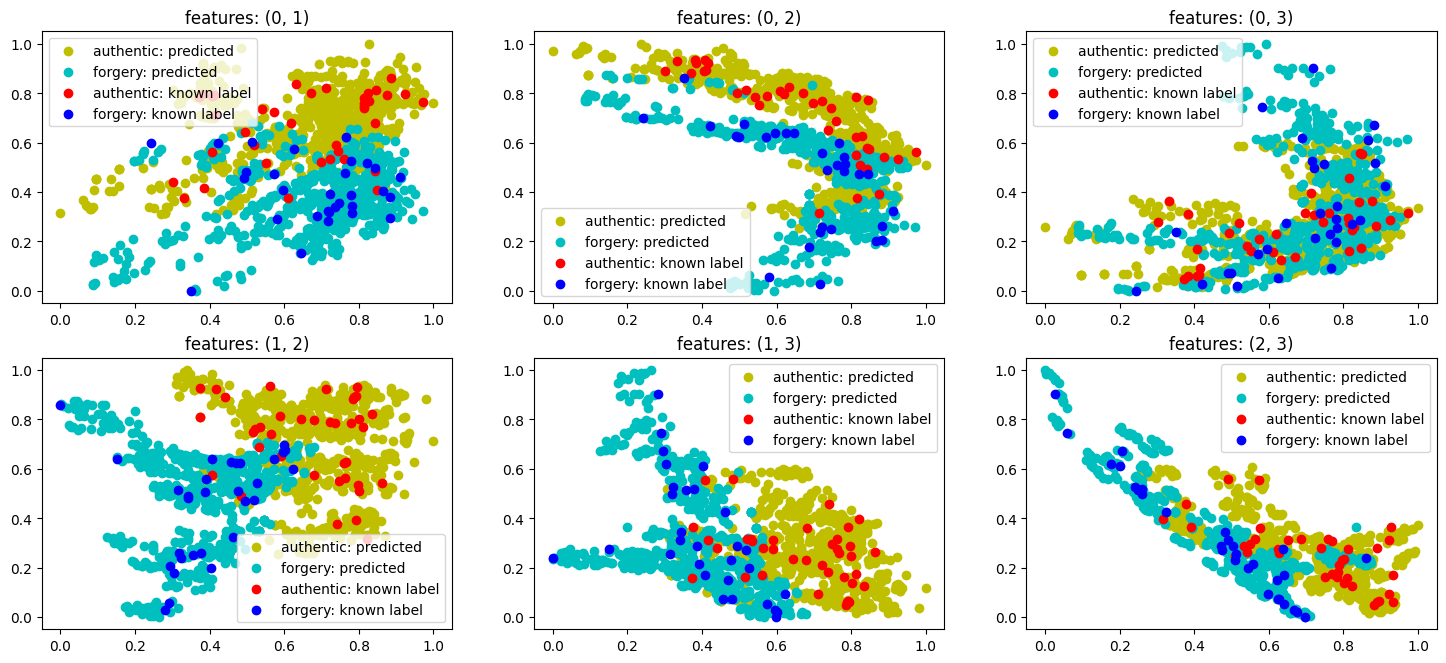

None


In [21]:
print(scatterplot_results(y_pred))
#print(scatterplot_3d_results(y_pred))

#BCGD

In [22]:
#@title Function to create blocks
def create_blocks(dim_blocks):
    B = []
    b = int(n_unlabeled/dim_blocks)
    if n_unlabeled % dim_blocks == 0:
        b -= 1
        
    indexes = np.array(range(n_unlabeled))
    for i in range(b):
        B.append(np.random.choice(indexes, dim_blocks, replace=False))
        indexes = np.setdiff1d(indexes, B[i])
    B.append(indexes)

    return B

In [23]:
#@title Randomized BCGD
np.random.seed(22)

# set parameters
epsilon = 0.0001 #@param [1e-4, 1e-3, 1e-2, 1e-1, 1] {type:"raw", allow-input: true}

f_y_unlabeled = f.eval(y_unlabeled)
stop = False
verbose = True
dim_blocks = 1 #@param {type:"slider", min:1, max:100, step:1}
blocks = create_blocks(dim_blocks)
mode = "L" #@param ["L", "armijo"]

# choose random point y0
y0 = -1 + 2 * np.random.rand(n_unlabeled)
f_y0 = f.eval(y0)
#print('f(y_unlabeled):', f_y_unlabeled)
#print('f(y0):', f_y0, '\n')

# variables for accuracy and time-grad plots
acc_history_rBCGD = []
err_history_rBCGD = []
time_history_rBCGD = []

# initialize global variables
y_k = y0
f_y_k = f_y0
s = 0
it = 0
acc2 = 0
patience = n_samples*2

# start time
start_time = time.time()

# start iteration --------------------------------------------------------------
while not stop:

    i = np.random.randint(len(blocks))
    b = blocks[i]

    if it == 0:
        list_subgrads = [f.gradient(y_k, indexes=block) for block in blocks]
        norm_subgrads = np.array([np.linalg.norm(subgrad)**2 for subgrad in list_subgrads])
        norm_grad_2 = np.sum(norm_subgrads)
    else:
        norm_grad_2 -= norm_subgrads[i]
        list_subgrads[i] = f.gradient(y_k, indexes=b)
        norm_subgrads[i] = np.linalg.norm(list_subgrads[i])**2
        norm_grad_2 += norm_subgrads[i]

    
    subgrad = list_subgrads[i]
    #subgrad = f.gradient(y_k, indexes=b)
    
    #f_old = f_y_k

    # update alpha
    if mode == 'armijo':
      alpha, f_y_k, skip = armijo(y_k, subgrad, indexes=b)
    else:
      alpha = 1 / f.L

    # update y_k
    y_k[b] = y_k[b] - alpha * subgrad

    # update error history
    norm_grad = np.sqrt(norm_grad_2)
    err_history_rBCGD.append(norm_grad)

    # update accuracy history
    y_pred_k = np.apply_along_axis(np.vectorize(lambda x: 1 if x>0 else -1), axis=0, arr=y_k)
    miss_k = int(sum(abs(y_unlabeled - y_pred_k)/2))
    acc_history_rBCGD.append(1 - miss_k/n_samples)

    # stopping criterion 
    if it%patience ==0:
      acc1 = acc2
      acc2 = acc_history_rBCGD[-1]
      if acc1 == acc2:
        stop = True
    

    # update iterations
    it += 1    

    # update time history
    iter_time = time.time()
    time_history_rBCGD.append(iter_time-start_time)

    if verbose and (it%1000 == 0):
        if mode == 'L':
            f_y_k = f.eval(y_k)
        print('Iteration:', it, '  \tf(y_k) =', f_y_k, '\t ||grad|| =', norm_grad)



# end iterations ---------------------------------------------------------------

# end time
end_time = time.time()

# adjust error and time history
#err_history_rBCGD = err_history_rBCGD[:-patience]
#time_history_rBCGD = time_history_rBCGD[:-patience]
#acc_history_rBCGD = acc_history_rBCGD[:-patience]

# print results
y_pred = np.apply_along_axis(np.vectorize(lambda x: 1 if x>0 else -1), axis=0, arr=y_k)
print()
#print('min f(y) =', f.eval(y_k))
#print('f(y_pred) =', f.eval(y_pred))
print('misclassified data:\t', int(sum(abs(y_unlabeled - y_pred)/2)))
print('accuracy: \t', acc_history_rBCGD[-1])
print('running time: \t', end_time - start_time, 's')
print('iterations: \t', it)
#print('last alpha: \t', alpha)

Iteration: 1000   	f(y_k) = 7775.425758189836 	 ||grad|| = 1078.238190494162
Iteration: 2000   	f(y_k) = 4884.10642900891 	 ||grad|| = 899.9449438929665
Iteration: 3000   	f(y_k) = 3554.597779815873 	 ||grad|| = 703.5303102216465
Iteration: 4000   	f(y_k) = 2707.4279119873772 	 ||grad|| = 541.5601260690253
Iteration: 5000   	f(y_k) = 2107.247447342139 	 ||grad|| = 435.43339599207883
Iteration: 6000   	f(y_k) = 1762.8838491038898 	 ||grad|| = 337.8396006307794
Iteration: 7000   	f(y_k) = 1581.2107398131532 	 ||grad|| = 284.23221989590496
Iteration: 8000   	f(y_k) = 1442.5710406134424 	 ||grad|| = 220.0205742359981
Iteration: 9000   	f(y_k) = 1348.7165153400902 	 ||grad|| = 172.0851524645812
Iteration: 10000   	f(y_k) = 1265.5003181582438 	 ||grad|| = 148.153743550263
Iteration: 11000   	f(y_k) = 1199.6475203669136 	 ||grad|| = 127.38625971978959
Iteration: 12000   	f(y_k) = 1147.2596053543937 	 ||grad|| = 116.53105008234697
Iteration: 13000   	f(y_k) = 1098.8795454397857 	 ||grad|| = 96

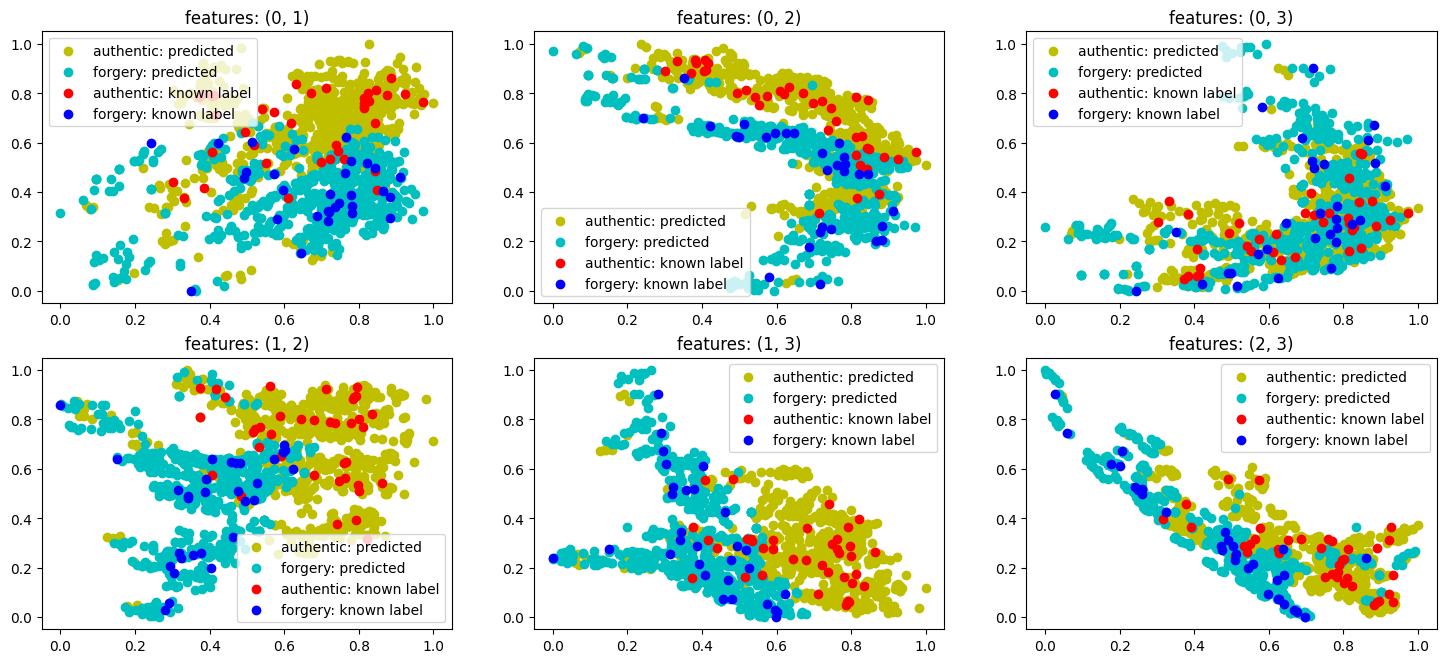

None


In [24]:
print(scatterplot_results(y_pred))
#print(scatterplot_3d_results(y_pred))

In [25]:
#@title BCGD with GS rule
np.random.seed(22)

# set parameters
epsilon = 0.0001 #@param [1e-10, 1e-7, 1e-4, 1e-3, 1e-2, 1e-1, 1] {type:"raw", allow-input: true}

f_y_unlabeled = f.eval(y_unlabeled)
stop = False
verbose = True
dim_blocks = 1 #@param {type:"slider", min:1, max:100, step:1}
blocks = create_blocks(dim_blocks)
mode = "L" #@param ["L", "armijo"]

# choose random point y0
y0 = -1 + 2 * np.random.rand(n_unlabeled)
f_y0 = f.eval(y0)
#print('f(y_unlabeled):', f_y_unlabeled)
#print('f(y0):', f_y0, '\n')

# variables for accuracy and time-grad plots
acc_history_GS = []
err_history_GS = []
time_history_GS = []

# initialize global variables
y_k = y0
f_y_k = f_y0
s = 0
it = 0
acc2 = 0
patience = n_samples*2

# start time
start_time = time.time()

# start iteration --------------------------------------------------------------
while not stop:

    # select random block in blocks
    if it == 0:
        list_subgrads = [f.gradient(y_k, indexes=block) for block in blocks]
        norm_subgrads = np.array([np.linalg.norm(subgrad)**2 for subgrad in list_subgrads])
        norm_grad_2 = np.sum(norm_subgrads)
    else:
        norm_grad_2 -= norm_subgrads[i_max]
        list_subgrads[i_max] = f.gradient(y_k, indexes=b)
        norm_subgrads[i_max] = np.linalg.norm(list_subgrads[i_max])**2
        norm_grad_2 += norm_subgrads[i_max]
        
    
    i_max = norm_subgrads.argmax()
    b = blocks[i_max]
    max_subgrad = list_subgrads[i_max]
    
    f_old = f_y_k

    # update alpha 
    if mode == 'armijo':
      alpha, f_y_k, skip = armijo(y_k, max_subgrad, indexes=b)
    else:
      alpha = 1 / f.L

    # update y_k
    y_k[b] = y_k[b] - alpha * max_subgrad

    # update error history
    norm_grad = np.sqrt(norm_grad_2)
    err_history_GS.append(norm_grad)

    # update accuracy history
    y_pred_k = np.apply_along_axis(np.vectorize(lambda x: 1 if x>0 else -1), axis=0, arr=y_k)
    miss_k = int(sum(abs(y_unlabeled - y_pred_k)/2))
    acc_history_GS.append(1 - miss_k/n_samples)

    # stopping criterion 
    if it%patience ==0:
      acc1 = acc2
      acc2 = acc_history_GS[-1]
      if acc1 == acc2:
        stop = True

    # update iterations
    it += 1

    if verbose and (it%1000 == 0):
        if mode == 'L':
            f_y_k = f.eval(y_k)
        print('max subgrad', max_subgrad, 'Iteration:', it, '  \tf(y_k) =', f_y_k, '\t ||grad|| =', norm_grad)
  

    # update time history
    iter_time = time.time()
    time_history_GS.append(iter_time-start_time)
# end iterations ---------------------------------------------------------------

# end time
end_time = time.time()

# adjust error and time history
#err_history_GS = err_history_GS[:-patience]
#time_history_GS = time_history_GS[:-patience]
#acc_history_GS = acc_history_GS[:-patience]

# print results
y_pred = np.apply_along_axis(np.vectorize(lambda x: 1 if x>0 else -1), axis=0, arr=y_k)
print('min f(y) =', f.eval(y_k))
#print('f(y_pred) =', f.eval(y_pred))
print('accuracy: \t', acc_history_GS[-1])
print('misclassified data:\t', int(sum(abs(y_unlabeled - y_pred)/2)))
print('running time: \t', end_time - start_time, 's')
print('iterations: \t', it)
#print('last alpha:', alpha)

max subgrad [17.97451383] Iteration: 1000   	f(y_k) = 3638.8316657752803 	 ||grad|| = 404.60193019736386
max subgrad [9.74921709] Iteration: 2000   	f(y_k) = 2310.682789110863 	 ||grad|| = 239.7749017853895
max subgrad [6.30790092] Iteration: 3000   	f(y_k) = 1820.5229622016664 	 ||grad|| = 160.15290375106972
max subgrad [-4.33834565] Iteration: 4000   	f(y_k) = 1592.5832200449224 	 ||grad|| = 113.23224888622917
max subgrad [-3.30782487] Iteration: 5000   	f(y_k) = 1461.1028769129628 	 ||grad|| = 84.11115019121436
max subgrad [2.41454649] Iteration: 6000   	f(y_k) = 1386.1916982230734 	 ||grad|| = 63.96677577739525
max subgrad [-1.88860133] Iteration: 7000   	f(y_k) = 1335.8562350937955 	 ||grad|| = 50.08407856056802
max subgrad [-1.51448436] Iteration: 8000   	f(y_k) = 1292.639974336647 	 ||grad|| = 40.93438952395873
max subgrad [1.2455645] Iteration: 9000   	f(y_k) = 1260.477179286045 	 ||grad|| = 34.13308082360418
max subgrad [1.09681331] Iteration: 10000   	f(y_k) = 1230.2784017931

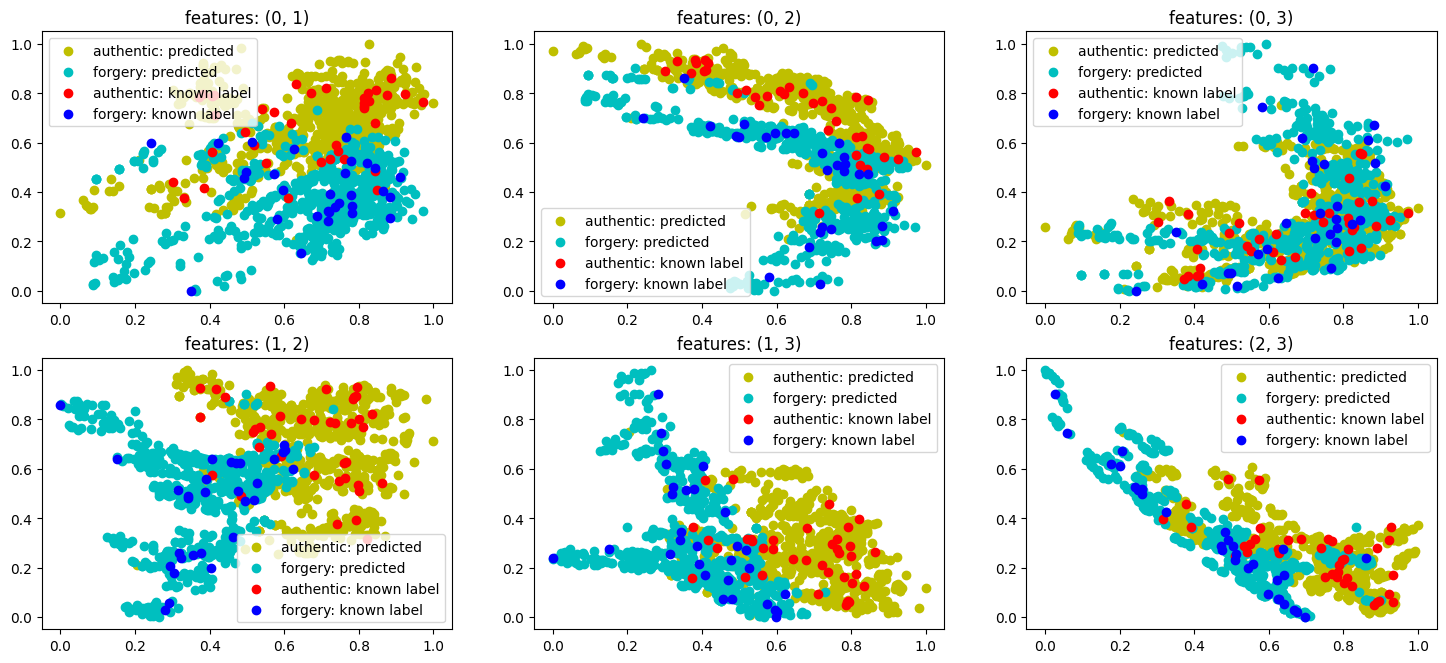

None


In [26]:
print(scatterplot_results(y_pred))
#print(scatterplot_3d_results(y_pred))

In [27]:
fig = px.scatter_3d(x=X_unlabeled[:,0], y=X_unlabeled[:,1], z=X_unlabeled[:,2], color=y_k*3, size=np.ones(n_unlabeled)*0.5)
fig.add_trace(px.scatter_3d(x=X_labeled[:,0], y=X_labeled[:,1], z=X_labeled[:,2], color=y_labeled, size=np.ones(n_labeled)*0.5).data[0] )
fig.show()

In [28]:
#@title Plot to compare different methods
def compare_convergence_rates():
    
    x_GD = np.array(range(len(err_history_GD)))
    x_rBCGD = np.array(range(len(err_history_rBCGD)))
    x_GS = np.array(range(len(err_history_GS)))
    plt.figure(figsize=(9, 4))
    #plt.suptitle("Compare rates of methods")
    
    plt.subplot(1, 2, 1)
    plt.plot(x_GD, np.log10(err_history_GD), label= 'Gradient Descent')
    plt.plot(x_rBCGD, np.log10(err_history_rBCGD), label= 'Randomized BCGD')
    plt.plot(x_GS, np.log10(err_history_GS), label= 'GS BCGD')
    plt.xlabel('Iteration')
    plt.ylabel('log10(Error)')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(time_history_GD, np.log10(err_history_GD), label= 'Gradient Descent')
    plt.plot(time_history_rBCGD, np.log10(err_history_rBCGD), label= 'Randomized BCGD')
    plt.plot(time_history_GS, np.log10(err_history_GS), label= 'GS BCGD')
    plt.xlabel('Time')
    #plt.ylabel('log10(Error)')
    plt.legend(loc='best')

    plt.show()

In [29]:
def compare_accuracy():

    plt.figure(figsize=(4, 4))
    #plt.suptitle()
    plt.plot(time_history_GD, acc_history_GD, label= 'Gradient Descent')
    plt.plot(time_history_rBCGD, acc_history_rBCGD, label= 'Randomized BCGD')
    plt.plot(time_history_GS, acc_history_GS, label= 'GS BCGD')
    plt.xlabel('Time')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.show()

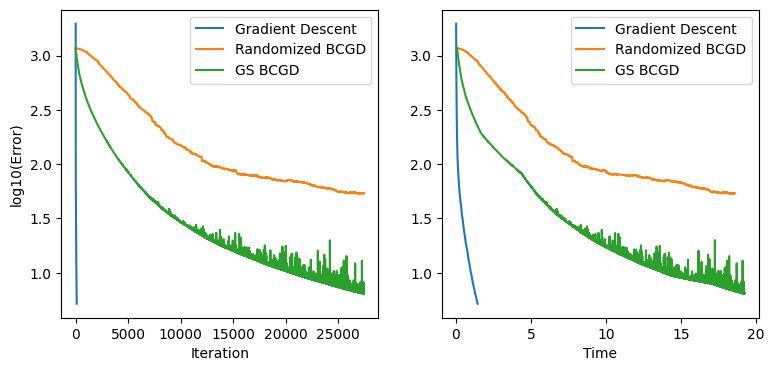

In [30]:
compare_convergence_rates()

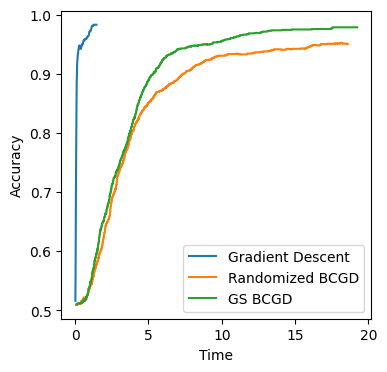

In [31]:
compare_accuracy()